In [85]:
import MySQLdb
import sshtunnel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import Lasso
from ast import literal_eval
import matplotlib.pyplot as plt
import glob
from pathlib import Path
import utils
from params import phase_2_statements
from tabulate import tabulate
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

temp_datetime = utils.get_datetime_str()

In [17]:
sshtunnel.SSH_TIMEOUT = 5.0
sshtunnel.TUNNEL_TIMEOUT = 5.0

with sshtunnel.SSHTunnelForwarder(
    ('ssh.pythonanywhere.com'),
    ssh_username='Grawi', ssh_password='midgeq-xikFah-gukpu7',
    remote_bind_address=('Grawi.mysql.pythonanywhere-services.com', 3306)
) as tunnel:
    print("Successfully connected to Pythonanywhere")
    connection = MySQLdb.connect(
        user='Grawi',
        passwd='david2202087',
        host='127.0.0.1', port=tunnel.local_bind_port,
        db='Grawi$Interactive_quiz_database',
    )
    # Do stuff
    print("Successfully connected to database")
    
    try:
        cursor = connection.cursor()
        query = "SELECT * FROM pilot_2 where submit_time>='2024-01-20';"
        df = pd.read_sql(query, connection)
        print(f"Data read finished, length {len(df)}")
    except Exception as e:
        print("Error:", e)
    
    finally:
        # Close the cursor and connection
        cursor.close()
        connection.close()

df["pilot_2_answers"] = df["pilot_2_answers"].map(literal_eval)
df['submit_time'] = pd.to_datetime(df['submit_time'])
df = df.loc[df["participantId"] != "testId"]
df.head()

Successfully connected to Pythonanywhere
Successfully connected to database
Data read finished, length 160


,participantId,assignmentId,projectId,attention_passed,total_time,pilot_2_answers,ideology_label,bot_detected,submit_time,identity_choices,ideologies,reason
0,015D95BA960E4D8387F933A0C7E87F69,46bffed0-5792-439f-bde5-ae94ff006e5e,7cc7f6f8-ec89-4df4-b229-6ca392644915,1,193.623,"[{'answer': 2, 'idx_of_question': 4}, {'answer...",0.9,None,2024-01-24 02:06:18,None,None,None
1,04B20429E15A4F91891F1AA6A65DEB2A,8f243e0c-c3a5-48d6-a638-01a4e94c365e,7cc7f6f8-ec89-4df4-b229-6ca392644915,1,227.511,"[{'answer': -2, 'idx_of_question': 6}, {'answe...",-2.0,None,2024-01-24 02:00:31,None,None,None
2,04BA8334EAC24523ACDDB56653A2CFA9,1cb2f0b4-1a42-44d9-8f6e-3ea29064726d,7cc7f6f8-ec89-4df4-b229-6ca392644915,1,173.285,"[{'answer': -1.5, 'idx_of_question': 4}, {'ans...",-1.0,None,2024-01-24 01:59:11,None,None,None
3,0790914064FA483CB0D3F41C9C7ECE27,d2f3d706-f5f2-4fe7-b39a-9524c1de02c2,7cc7f6f8-ec89-4df4-b229-6ca392644915,1,256.759,"[{'answer': 1, 'idx_of_question': 6}, {'answer...",0.0,None,2024-01-24 02:02:59,None,None,None
4,07994856BD944213BD589A588737BEBC,3be591a4-0dc1-4695-87cb-677493c0d469,7cc7f6f8-ec89-4df4-b229-6ca392644915,1,303.604,"[{'answer': -2.1, 'idx_of_question': 7}, {'ans...",-1.0,None,2024-01-24 02:01:45,None,None,None


In [19]:
df["ideology_label"] = df.apply(lambda row: row["ideology_label"] if row["submit_time"] >= pd.to_datetime("2024-01-09") else row["ideology_label"] - 2, axis=1)

ids_attention_failed = df.loc[df['attention_passed'] == 0]["participantId"].tolist()
print(f"Participants who failed attention check: {ids_attention_failed}")
df = df.loc[df["attention_passed"] == 1]
df = df.loc[:, ["participantId", "pilot_2_answers", "ideology_label"]].set_index("participantId")

def IdeologyToNumber(ideology):
    if ideology == "Moderate":
        return 0
    elif ideology == "Somewhat Conservative":
        return 1
    elif ideology == "Conservative":
        return 2
    elif ideology == "Somewhat Liberal": 
        return -1
    elif ideology == "Liberal":
        return -2

connect_data_csv = glob.glob('data/connect_raw_data/pilot-2-2*.csv')[0]
df_connect = pd.read_csv(connect_data_csv).set_index("ParticipantId")
df["connect_ideology"] = df_connect["Political Ideology"].map(IdeologyToNumber)
print("rmse of ideology:", np.sqrt(np.mean((df["ideology_label"] - df["connect_ideology"])**2)))
df["ideology"] = df["ideology_label"]
df.drop(["connect_ideology", "ideology_label"], axis=1, inplace=True)
df.head()

Participants who failed attention check: ['0E61CE23A6B14B9C9C3521FFEA15B30B', '5556B69CF17E47E5B2A64659E43400D2', 'BA366CE24A6245D0BFF165BA41E4F395', 'E4E86026F8E34035BF2702039FBDF5DF']
rmse of ideology: 0.6811566332161487


,pilot_2_answers,ideology
participantId,,
015D95BA960E4D8387F933A0C7E87F69,"[{'answer': 2, 'idx_of_question': 4}, {'answer...",0.9
04B20429E15A4F91891F1AA6A65DEB2A,"[{'answer': -2, 'idx_of_question': 6}, {'answe...",-2.0
04BA8334EAC24523ACDDB56653A2CFA9,"[{'answer': -1.5, 'idx_of_question': 4}, {'ans...",-1.0
0790914064FA483CB0D3F41C9C7ECE27,"[{'answer': 1, 'idx_of_question': 6}, {'answer...",0.0
07994856BD944213BD589A588737BEBC,"[{'answer': -2.1, 'idx_of_question': 7}, {'ans...",-1.0


### 1. The Answer Patter for Each Question

In [20]:
def IndexToType(index):
    if index >= 0 and index <= 3:
        return "prediction"
    elif index >= 4 and index <= 7:
        return "issue"
    elif index == 8 or index == 9:
        return "fact"

answers = {"index": [], "seq": [], "answer": [], "ideology": []}
for id, row in df.iterrows():
    pilot_2_answers = row["pilot_2_answers"]
    ideology = row["ideology"]
    tmp_seq = {"prediction": 0, "issue": 0, "fact": 0}
    for each_answer in pilot_2_answers:
        question_type = IndexToType(each_answer["idx_of_question"])
        answers["index"].append(each_answer["idx_of_question"])
        for type_question in phase_2_statements[question_type]:
            if type_question["index"] == each_answer["idx_of_question"]:
                if "alignment" in type_question and type_question["alignment"] == 0 or "alignment" not in type_question:
                    answers["answer"].append(each_answer["answer"])
                else:
                    answers["answer"].append(-each_answer["answer"])
                break
        answers["ideology"].append(ideology)
        answers["seq"].append(tmp_seq[question_type])
        tmp_seq[question_type] += 1
    
df_answers = pd.DataFrame(answers)
df_answers.head()

,index,seq,answer,ideology
0,4,0,2.0,0.9
1,3,0,0.9,0.9
2,5,1,3.0,0.9
3,2,1,1.4,0.9
4,6,2,3.0,0.9


#### 1.1 Distribution graph

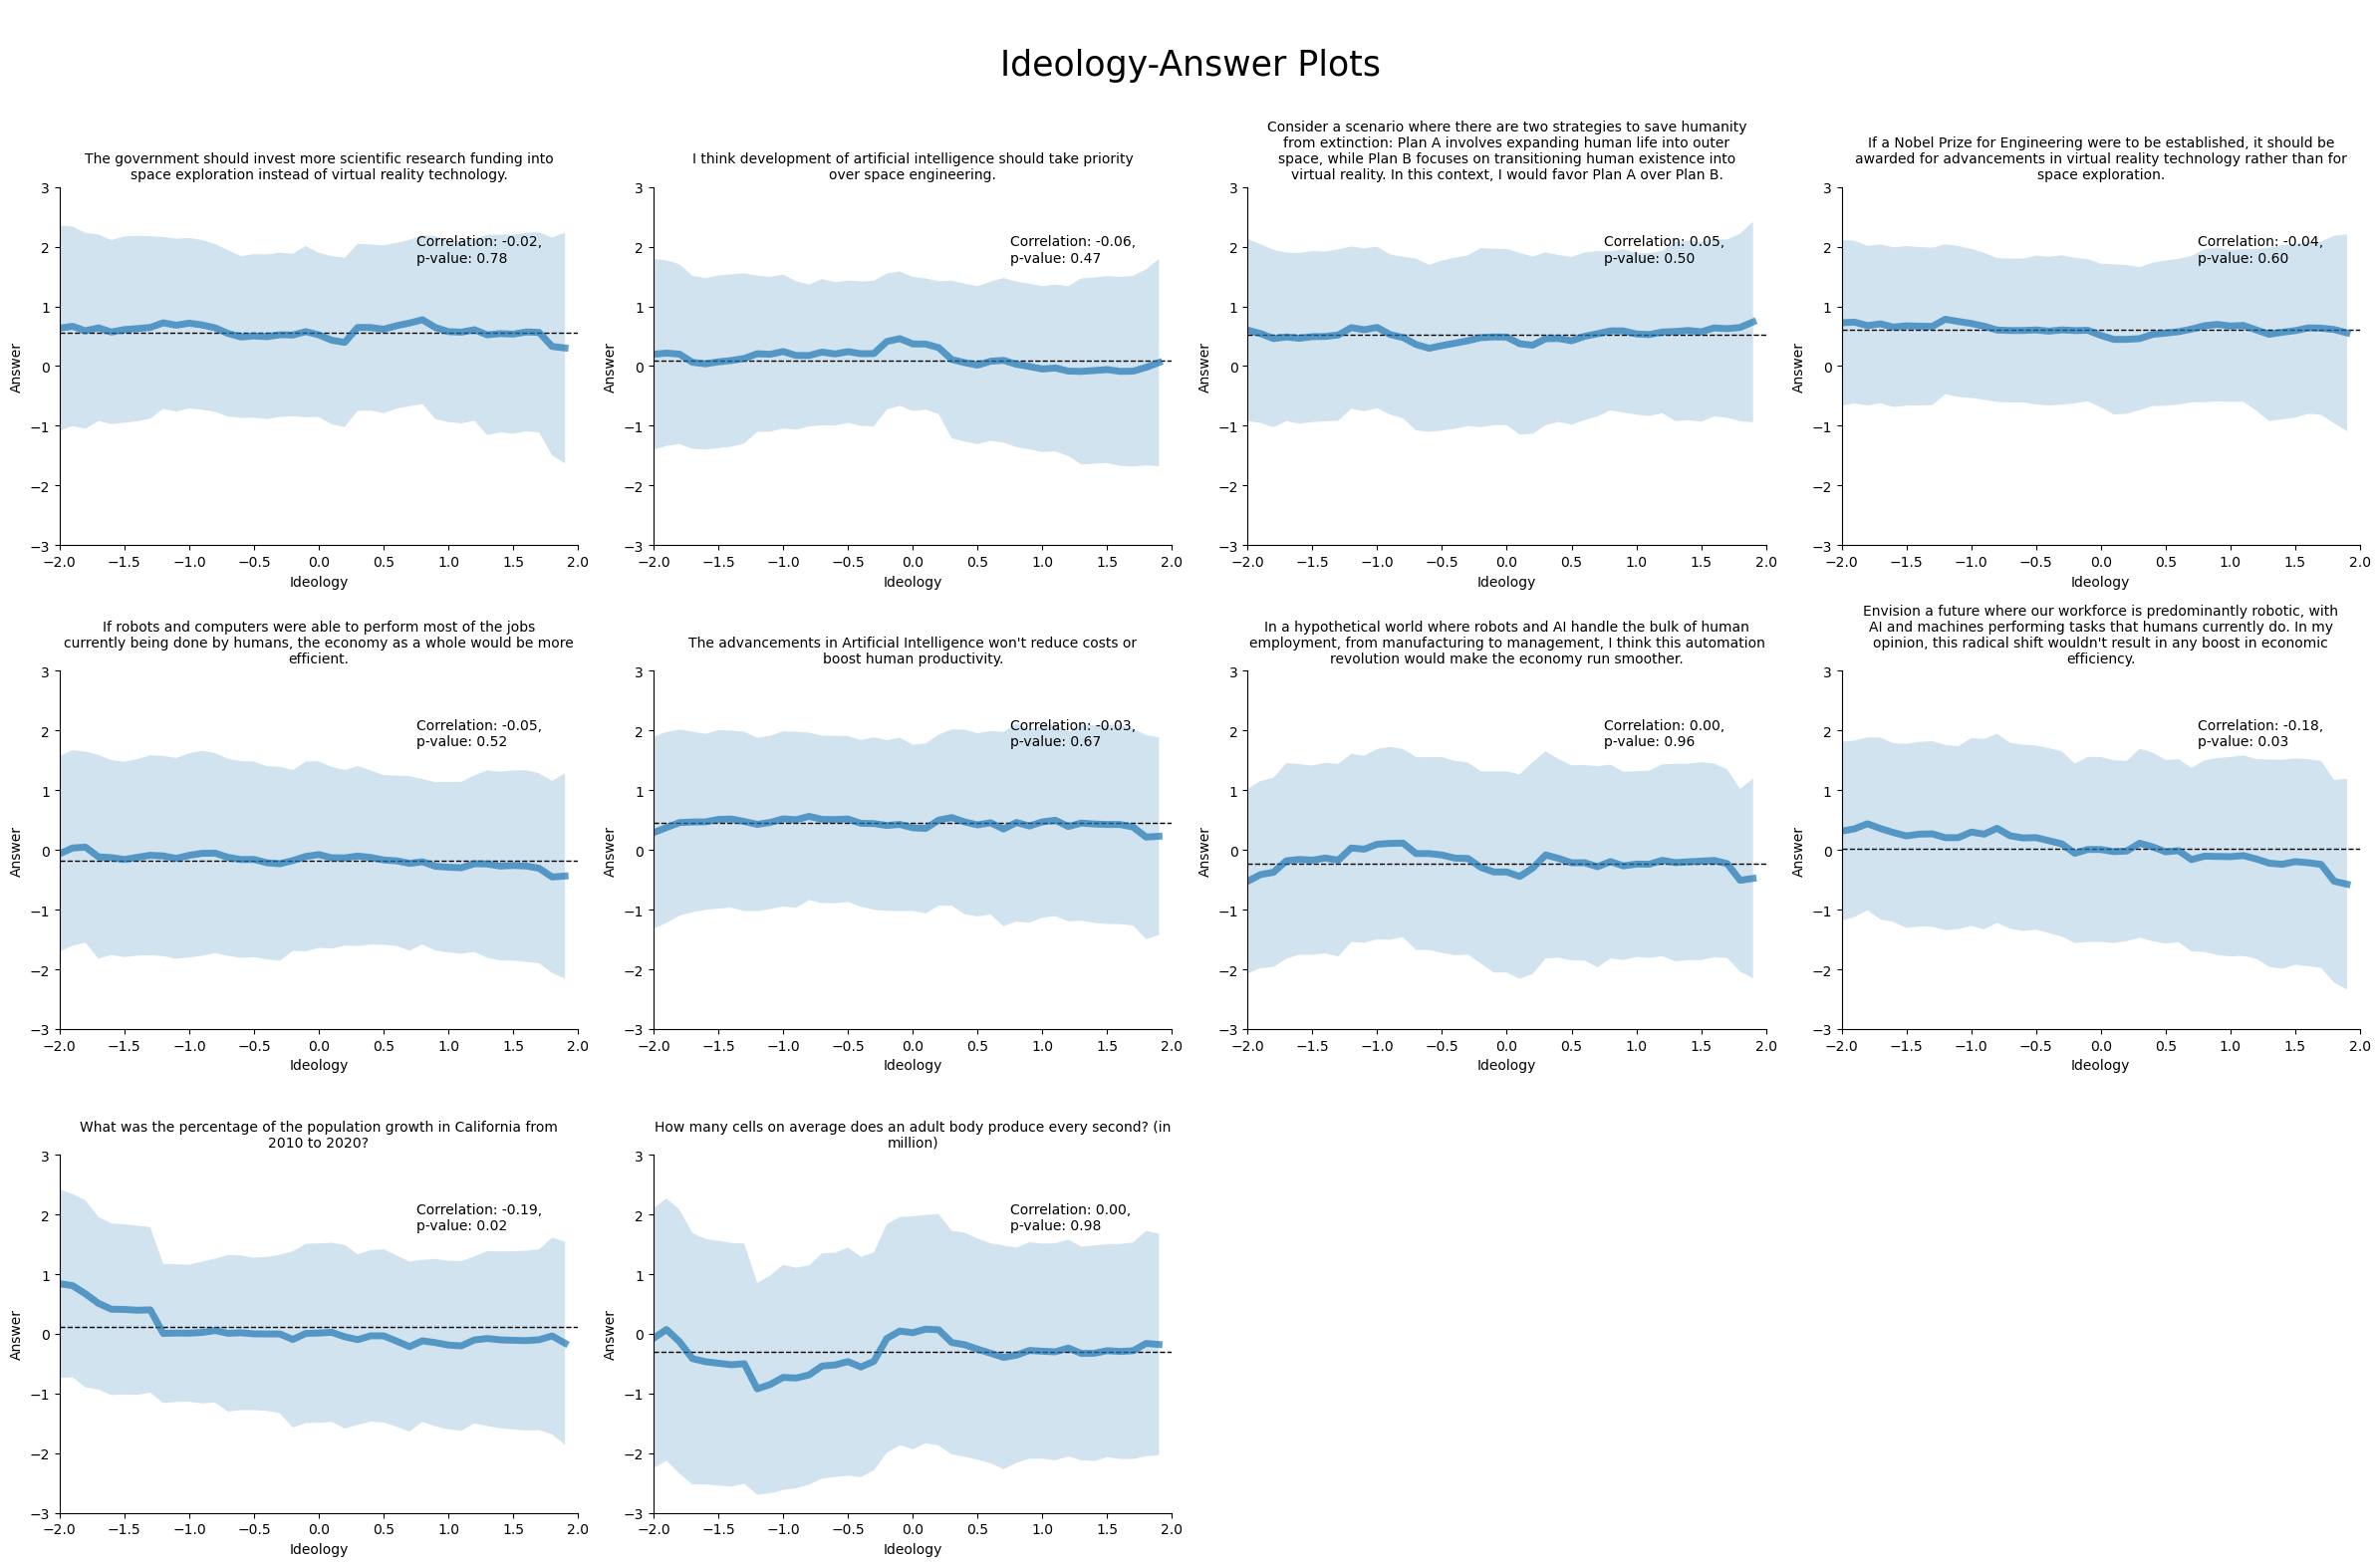

In [81]:
import textwrap

# 画图
fig, axes = plt.subplots(3, 4, figsize=(24, 16))
fig.suptitle("\nIdeology-Answer Plots\n", fontsize=25)
axes[2, 2].axis("off")
axes[2, 3].axis("off")

for index in range(10):
    ax = axes[index // 4][index % 4]
    ax.set(
        ylim=(-3, 3),
        xlim=(-2, 2),
        xlabel="Ideology",
        ylabel="Answer",
    )
    for type_question in phase_2_statements[IndexToType(index)]:
        if type_question["index"] == index:
            title = textwrap.fill(type_question["text"], 70)
            ax.set_title(title, fontsize=10)
            break
    x = df_answers.loc[df_answers["index"] == index]["ideology"]
    y = df_answers.loc[df_answers["index"] == index]["answer"]
    answer_avg = y.mean()
    ax.axhline(answer_avg, color="black", linestyle="--", linewidth=1)
    correlation = pearsonr(x, y)[0], pearsonr(x, y)[1]
    ax.text(0.75, 1.75, f"Correlation: {correlation[0]:.2f}, \np-value: {correlation[1]:.2f}", fontsize=10)
    average, low, high = utils.sliding_average(x, y)
    utils.plot_with_std(ax, average, low, high)

utils.savefig(fig, f"visualization/{temp_datetime}-pilot_2-questions.pdf")

#### 1.2 Correlation with ideology

In [9]:
# 和意识形态绝对值的相关系数
df_answers.groupby("index").apply(lambda x: pearsonr(x["answer"], abs(x["ideology"]))[0])

index
0    0.006912
1   -0.056580
2    0.062948
3    0.021219
4   -0.023938
5    0.007515
6   -0.061432
7   -0.050828
8    0.153089
9    0.049903
dtype: float64

### 2. Relationship Between Questions

#### 2.1 Correlation of answers for each pair of questions

In [30]:
def CalCorrelation(ind_1, ind_2, method="pearsonr"):
    df_1 = df_answers.loc[df_answers["index"] == ind_1]
    df_2 = df_answers.loc[df_answers["index"] == ind_2]
    if method == "pearsonr":
        result = pearsonr(df_1["answer"], df_2["answer"])
    elif method == "spearmanr":
        result = spearmanr(df_1["answer"], df_2["answer"])
    return result[0]

for method in ["pearsonr", "spearmanr"]:
    print("\n" + method + ":\n")
    for question_type in ["prediction", "issue"]:
        print("\n" + question_type + ":\n")
        row_labels = ["A1", "A2", "A3", "A4"]
        col_labels = ["A1", "A2", "A3", "A4"]
        table_data = []
        for row_idx, row_label in enumerate(row_labels):
            row_data = []
            for col_idx, col_label in enumerate(col_labels):
                if row_idx == col_idx:
                    row_data.append(None)
                else:
                    value = 0
                    if question_type == "prediction":
                        row_data.append(CalCorrelation(row_idx, col_idx, method))
                    elif question_type == "issue":
                        row_data.append(CalCorrelation(row_idx + 4, col_idx + 4, method))
            table_data.append(row_data)
        table = tabulate(table_data, headers=col_labels, showindex=row_labels, tablefmt='markdown', floatfmt=".2f")
        print(table)


pearsonr:


prediction:

      A1    A2    A3    A4
--  ----  ----  ----  ----
A1        0.36  0.66  0.34
A2  0.36        0.28  0.52
A3  0.66  0.28        0.25
A4  0.34  0.52  0.25

issue:

      A1    A2    A3    A4
--  ----  ----  ----  ----
A1        0.43  0.74  0.60
A2  0.43        0.42  0.41
A3  0.74  0.42        0.49
A4  0.60  0.41  0.49

spearmanr:


prediction:

      A1    A2    A3    A4
--  ----  ----  ----  ----
A1        0.40  0.68  0.37
A2  0.40        0.30  0.51
A3  0.68  0.30        0.31
A4  0.37  0.51  0.31

issue:

      A1    A2    A3    A4
--  ----  ----  ----  ----
A1        0.44  0.75  0.59
A2  0.44        0.41  0.41
A3  0.75  0.41        0.47
A4  0.59  0.41  0.47


#### 2.2 Scatter plots of answers for each pair of questions (with/ without rescaling)

In [54]:
df_scale = df_answers.groupby("index")["answer"].agg(["mean", "std"])
df_answers["answer_rescaled"] = df_answers.apply(lambda row: (row["answer"] - df_scale.loc[row["index"]]["mean"]) / df_scale.loc[row["index"]]["std"], axis=1)
df_answers["answer_rescaled"] = df_answers["answer_rescaled"].clip(lower=-3, upper=3)

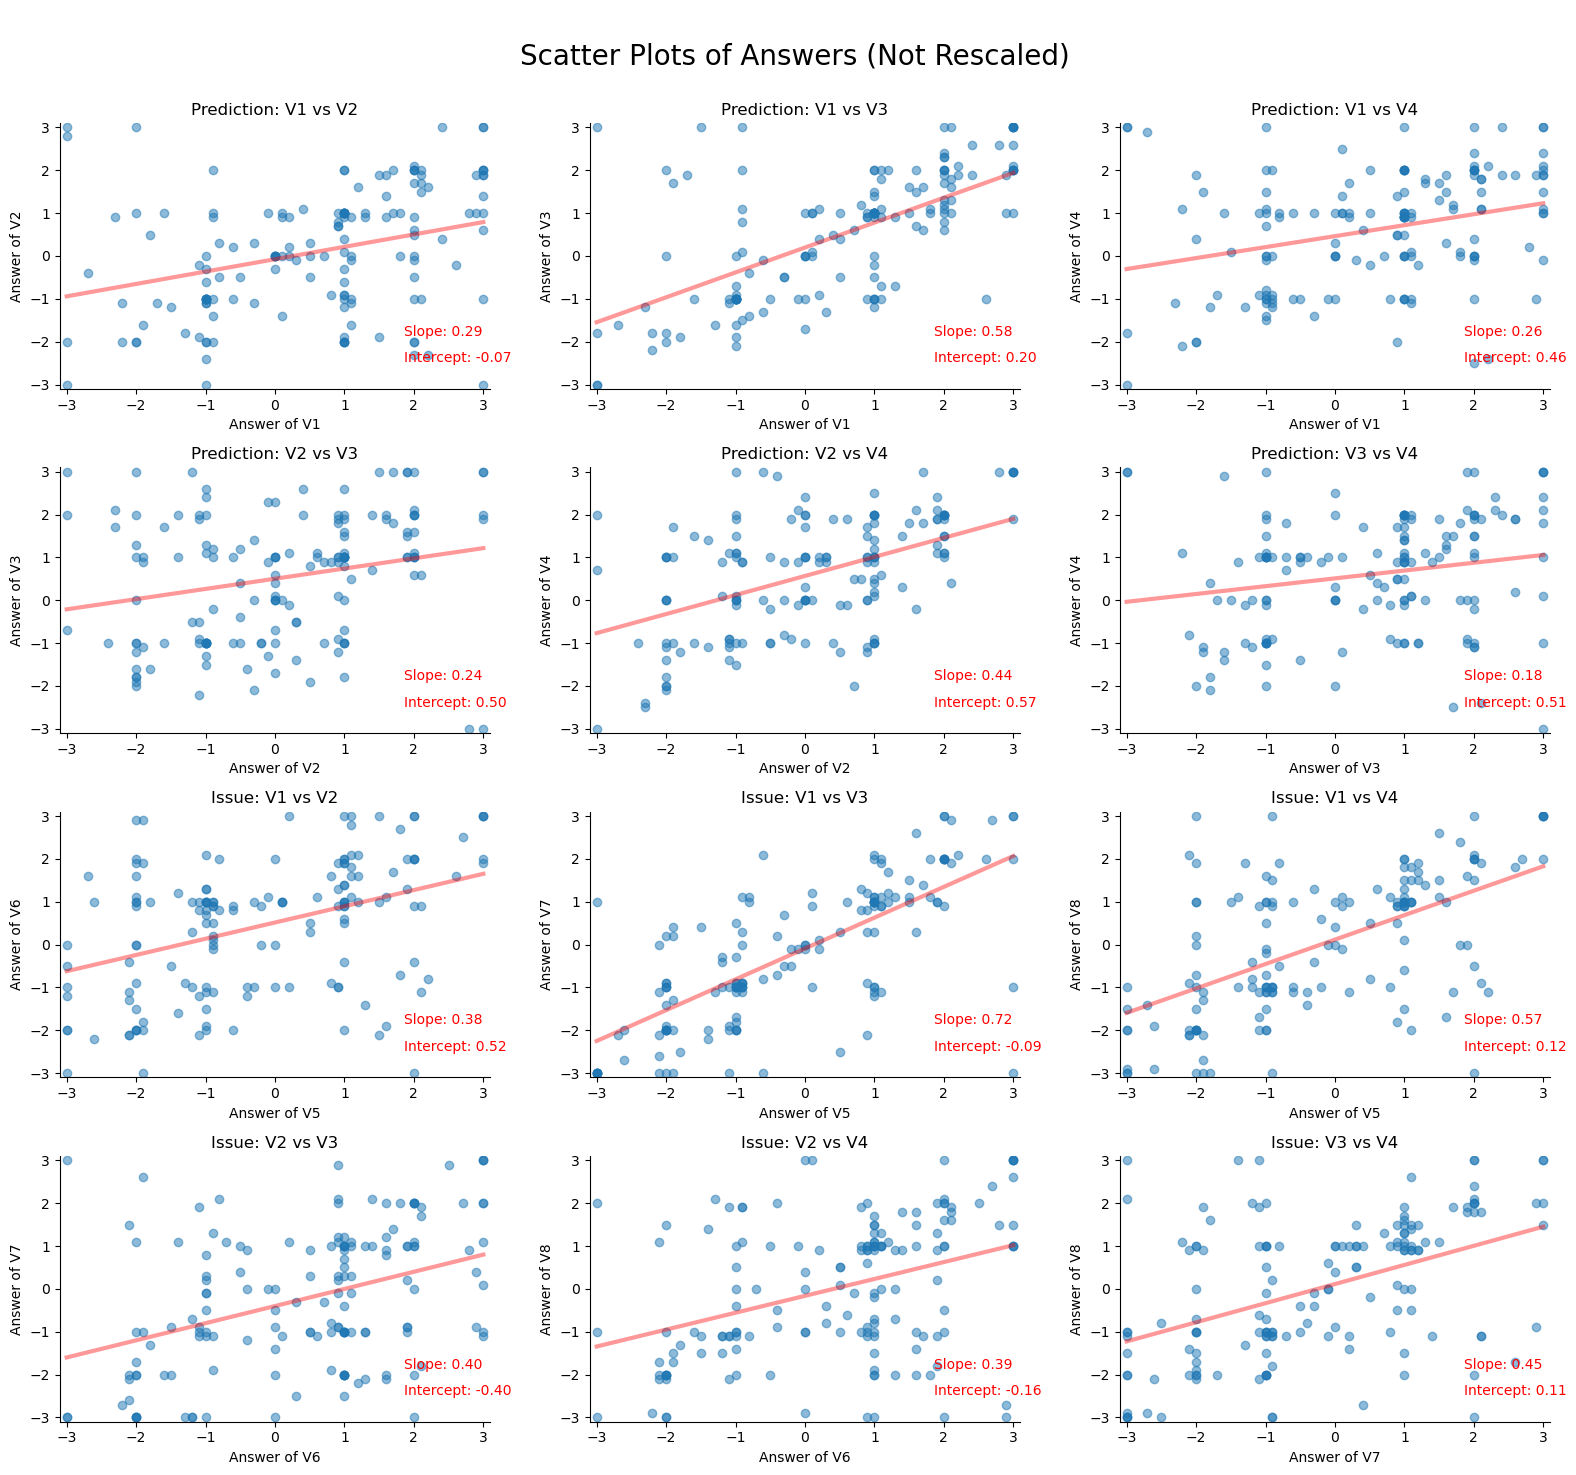

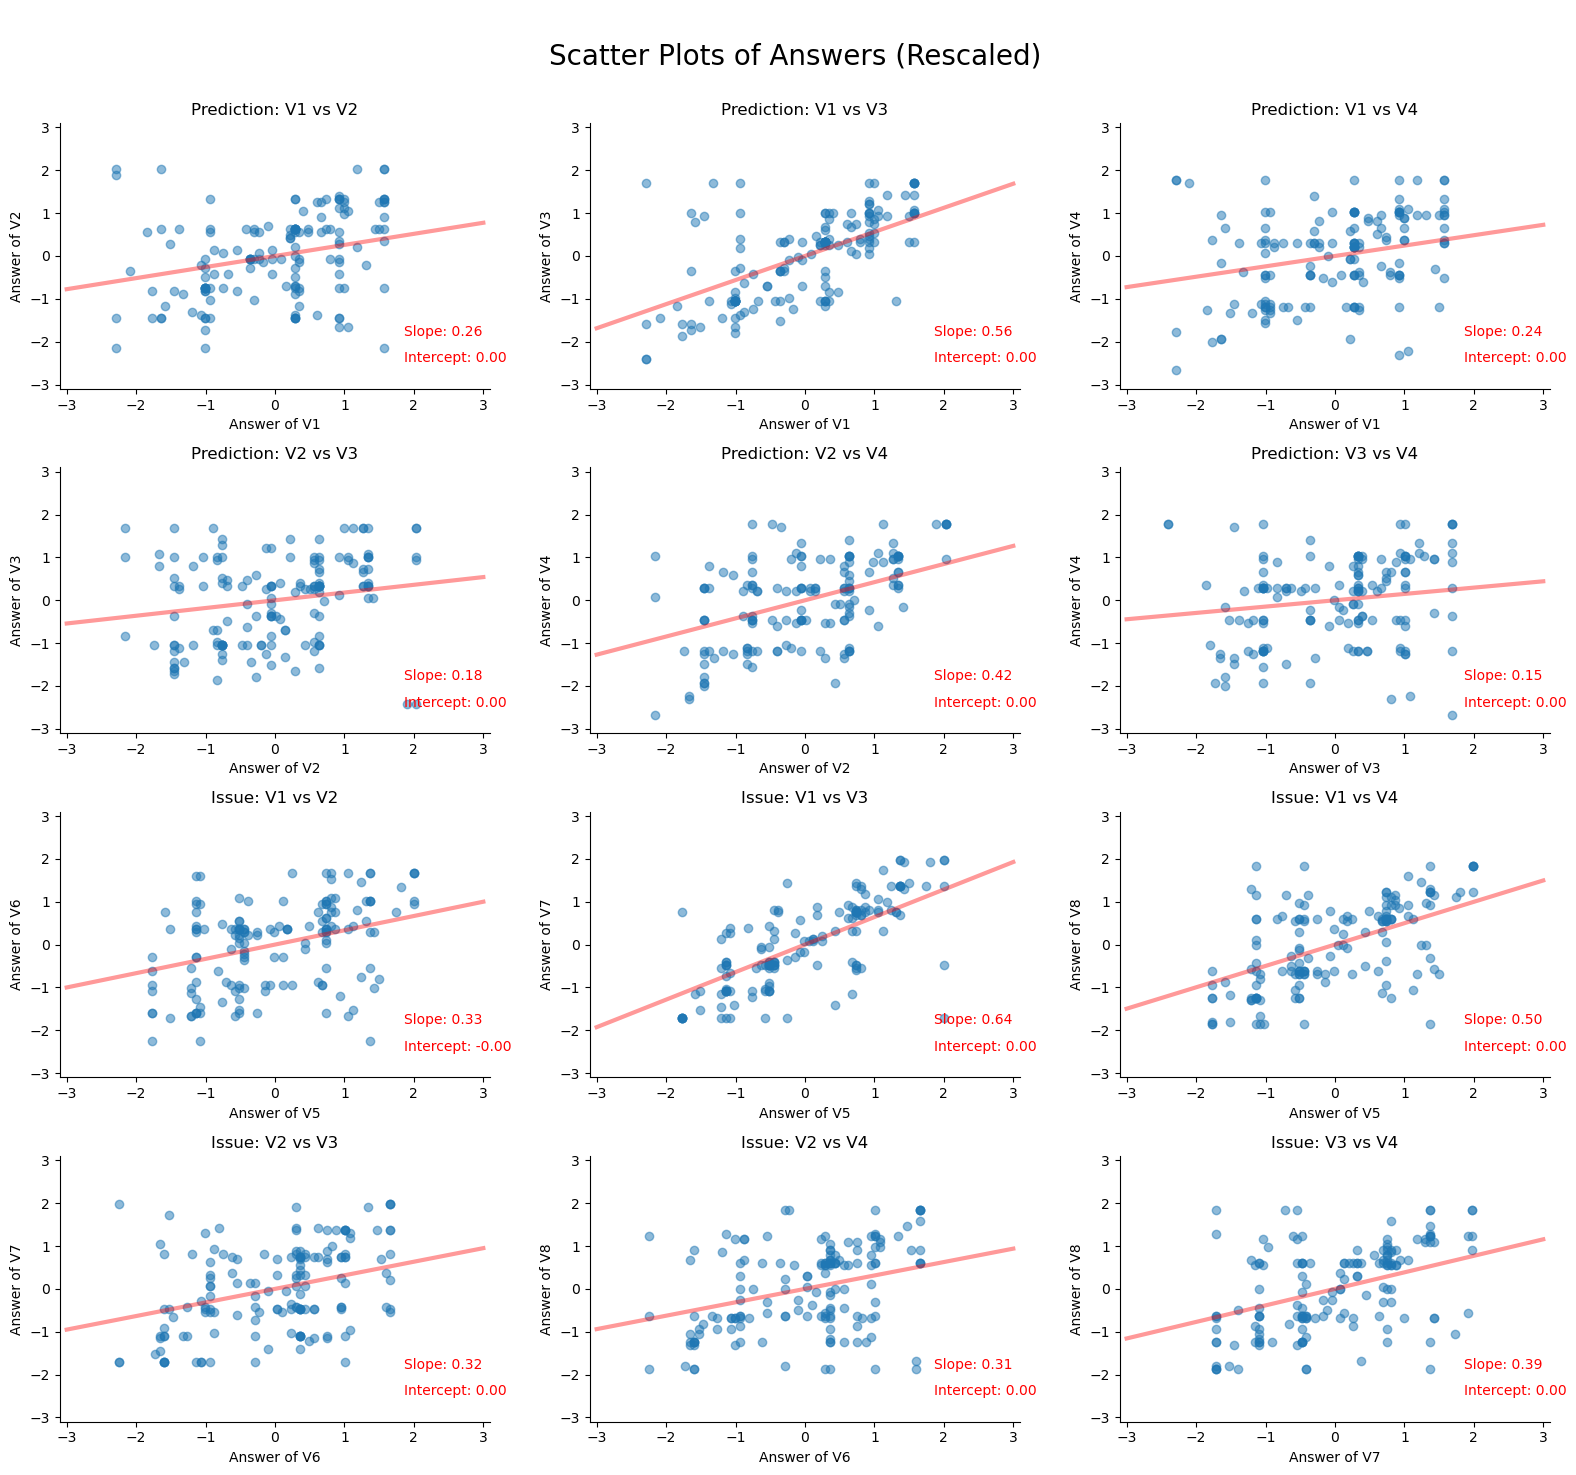

In [87]:
figure_size = (4, 5)

for rescale in [False, True]:
    fig, axes = plt.subplots(4, 3, figsize=(figure_size[0] * 4, figure_size[1] * 3))
    suptitle = f"\nScatter Plots of Answers (Rescaled)\n" if rescale else f"\nScatter Plots of Answers (Not Rescaled)\n"
    fig.suptitle(suptitle, fontsize=20)
    target_col = "answer_rescaled" if rescale else "answer"
    fig_idx = 0
    for question_type in ["prediction", "issue"]:
        for ind_1 in range(4):
            for ind_2 in range(ind_1 + 1, 4):
                ax = axes[fig_idx // 3][fig_idx % 3]
                ax.set(
                    ylim=(-3.1, 3.1),
                    xlim=(-3.1, 3.1),
                )
                x = None
                y = None
                if question_type == "prediction":
                    ax.set_title(f"Prediction: V{ind_1 + 1} vs V{ind_2 + 1}")
                    ax.set(
                        xlabel=f"Answer of V{ind_1 + 1}",
                        ylabel=f"Answer of V{ind_2 + 1}",
                    )
                    x = df_answers.loc[df_answers["index"] == ind_1][target_col]
                    y = df_answers.loc[df_answers["index"] == ind_2][target_col]
                elif question_type == "issue":
                    ax.set_title(f"Issue: V{ind_1 + 1} vs V{ind_2 + 1}")
                    ax.set(
                        xlabel=f"Answer of V{ind_1 + 5}",
                        ylabel=f"Answer of V{ind_2 + 5}",
                    )
                    x = df_answers.loc[df_answers["index"] == ind_1 + 4][target_col]
                    y = df_answers.loc[df_answers["index"] == ind_2 + 4][target_col]
                ax.scatter(x, y, alpha=0.5)

                # Calculate regression line parameters
                X = x.values.reshape(-1, 1)
                lasso = Lasso(alpha = 0.1)
                lasso.fit(X, y)
                slope = lasso.coef_[0]
                intercept = lasso.intercept_
                # slope, intercept = np.polyfit(x, y, 1)
                regression_x = np.array([-3, 3])
                regression_line = slope * regression_x + intercept

                # Plot regression line
                ax.plot(regression_x, regression_line, color='red', alpha=0.4, linewidth=3)

                # Label the parameters of the line
                ax.text(0.8, 0.2, f"Slope: {slope:.2f}", transform=ax.transAxes, color='red')
                ax.text(0.8, 0.1, f"Intercept: {intercept:.2f}", transform=ax.transAxes, color='red')

                fig_idx += 1

    # Save the figure with higher resolution
    utils.savefig(fig, f"test_{rescale}.jpg", dpi=600)

#### 2.3 PCA selection (with/ without rescaling)

In [84]:
for rescale in [False, True]:
    if rescale:
        print("\nRescaled: ")
    else:
        print("Not Rescaled: ")
    for question_type in ["prediction", "issue"]:
        M = np.zeros((len(df), 4), dtype=float)
        for index, (id, row) in enumerate(df.iterrows()):
            pilot_2_answers = row["pilot_2_answers"]
            for each_answer in pilot_2_answers:
                if question_type == "prediction":
                    if each_answer["idx_of_question"] < 4:
                        M[index][each_answer["idx_of_question"]] = each_answer["answer"]
                else:
                    if each_answer["idx_of_question"] >= 4 and each_answer["idx_of_question"] < 8:
                        M[index][each_answer["idx_of_question"] - 4] = each_answer["answer"]
        if rescale:
            scaler = MinMaxScaler(feature_range=(-3, 3))
            M = scaler.fit_transform(M)
        pca = PCA(n_components=1)
        pca.fit(M)
        M_pca = pca.transform(M)
        print("    ", question_type, pca.explained_variance_ratio_)

Not Rescaled: 
     prediction [0.56378277]
     issue [0.64550963]

Rescaled: 
     prediction [0.56378277]
     issue [0.64550963]


### 2. The Impact of Order for A Question

In [14]:
df_no_fact = df_answers.loc[df_answers["index"] <= 7]
pearsonr(df_no_fact["answer"], df_no_fact["seq"])

PearsonRResult(statistic=0.025363960752104217, pvalue=0.3645612671632392)

In [15]:
df_answers.groupby(["index", "seq"])["answer"].mean()

index  seq
0      0      0.461364
       1      0.542424
       2      0.430952
       3      0.719512
1      0      0.026667
       1      0.071795
       2      0.200000
       3     -0.031250
2      0      0.466667
       1      0.744186
       2      0.241935
       3      0.375000
3      0      0.009375
       1      0.688889
       2      0.818182
       3      0.679487
4      0     -0.408108
       1     -0.587805
       2     -0.052174
       3      0.397222
5      0      0.815625
       1      0.240000
       2      0.582927
       3      0.269048
6      0      0.133333
       1     -0.284211
       2     -0.450000
       3     -0.278049
7      0     -0.106522
       1     -0.133333
       2      0.275676
       3      0.126829
8      0      0.120000
9      1     -0.260938
Name: answer, dtype: float64